In [2]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
from collections import Counter
import seaborn
from scipy import stats
from tqdm import tqdm_notebook


%matplotlib inline

In [3]:
data_cam_df = pd.read_csv('xcms_pigs_camera.csv', sep = ',', index_col=0)

In [4]:
service_cols = ["mz", "mzmin", "mzmax", "rt", "rtmin", "rtmax", ".", "npeaks", "isotopes", "adduct", "pcgroup"]
assert len(set(service_cols) - set(data_cam_df.columns))==0
samples_cols = list(set(data_cam_df.columns) - set(service_cols))

In [5]:
data_cam_df[data_cam_df==0]=np.nan
data_cam_df[samples_cols] = np.log(data_cam_df[samples_cols])

## standards

#### TAG

In [6]:
new_mz_palm = np.abs((data_cam_df['mz'] - 811.765)) / 811.765 
new_mz_palm = new_mz_palm * 1000000
sunf_ppm_palm = data_cam_df[new_mz_palm<13]

In [7]:
sunf_ppm_palm.head()
sunf_ppm_palm.index

Int64Index([2011], dtype='int64')

In [8]:
RO=pd.Series([i.split('_')[3][1:] if 'S' in i else i for i in data_cam_df.columns],index=data_cam_df.columns)

In [9]:
for i in RO.index:
    try:
        RO[i]=int(RO[i])
    except:
        RO[i]=np.nan

In [10]:
RO=RO.dropna()

In [11]:
rt_in_min = data_cam_df['rt']/60
data_cam_df['rt'] = rt_in_min
data_cam_filt_rt_df = data_cam_df[(data_cam_df['rt'] > 0.6) & (data_cam_df['rt'] < 19)]
data_cam_filt_rt_df.head(4)

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_15_1.100_pos,X171208_pigs_scat2_18_1.100_pos,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,11.927535,11.867717,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105
2,133.100423,133.099922,133.101013,3.391133,202.231,204.805,69,69,10.248525,11.050215,...,10.273095,9.808182,10.138165,9.222282,10.018860,10.075920,9.181783,NaN,[M+3H-C6H10O4]3+ 542.333,37
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,9.952731,9.736448,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17
4,149.022196,149.021515,149.022699,4.672275,268.144,286.492,140,75,14.002570,13.957953,...,14.030105,14.237696,14.040697,14.005739,14.212340,14.243009,14.031754,NaN,NaN,61


In [12]:
del_isotopes = data_cam_filt_rt_df['isotopes'].str.match(r'\[\d+\]\[M\+\d+\]\+').fillna(False)
#[m][M+n]+ где n от 1, m from 1
data_cam_filt_rt_iso_df = data_cam_filt_rt_df[~del_isotopes]

### after Anya filtering

In [13]:
filtering_res = np.load('cleanedpeaks.npy')

In [14]:
filtering_res_indices = sorted(set(data_cam_filt_rt_iso_df.index) & set(filtering_res))

In [15]:
data_filtering = data_cam_filt_rt_iso_df.loc[filtering_res_indices]

In [16]:
annot_data = pd.read_csv('xcms_pigs_camera.csv.ann.txt', sep = ',', index_col=0)
#loading data

In [17]:
lmfa_index = annot_data['lm_id'].str.contains('LMFA0101').fillna(False)
#строки в annot_data которые содержать LMFA0101 + что-то
lmfa_annot_data = annot_data[lmfa_index]
lmfa_annot_data = annot_data[lmfa_index]
#беру из annot_data строки которые соответствуют строкам в которых есть LMFA0101 + что-то

In [18]:
annot_data_no_null = annot_data[~annot_data['lm_id'].isnull()]

In [19]:
annot_groups = []

for index, data in annot_data_no_null.groupby(annot_data_no_null.index):
    annot_groups.append({
        "index": index,
        "lm_id": ";".join(data.lm_id),
        "adduct_annot": ";".join(data.adduct)
    })
    
annot_groups = pd.DataFrame(annot_groups)
annot_groups.set_index('index', inplace=True)

In [20]:
data_cam_filt_rt_iso_df_annot = pd.merge(data_cam_filt_rt_iso_df, annot_groups, left_index=True, right_index=True)
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,13.196349,12.749017,...,13.196748,13.158301,13.198074,13.357146,13.152200,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,11.039007,11.716192,...,10.897606,9.385198,10.667300,10.833208,8.944734,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,9.668170,10.678359,...,9.754414,10.162118,9.580330,9.686382,9.741953,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,11.970738,12.069558,...,12.517894,13.089057,12.177053,12.927467,12.069352,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,10.092041,8.713289,...,10.278754,10.091371,9.983209,9.925269,10.157924,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,9.976485,10.203494,...,10.141990,10.267574,8.180022,10.216156,10.443502,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,10.914870,10.758726,...,11.093819,10.375224,10.442637,11.359048,10.443721,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,12.158058,11.661869,...,12.222774,12.146986,12.148198,12.093720,12.165402,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [21]:
data_cam_filt_rt_iso_df_annot.drop(["X171208_pigs_scat1_1_15_1.100_pos", "X171208_pigs_scat1_2_15_1.100_pos"], axis = 1, inplace = True)
data_cam_filt_rt_iso_df_annot.rename(columns={"X171208_pigs_LM3_1_11_1.50_pos": "X171208_pigs_LM3_11_1.50_pos",
                                             "X171206_pigs_scat1_3_15_pos_1.100": "X171208_pigs_scat1_15_1.100_pos"}, inplace=True)

## T-test

In [22]:
all_columns = data_cam_filt_rt_iso_df_annot.columns.tolist()
samples_columns = all_columns[all_columns.index('X171208_pigs_scat1_15_1.100_pos'):all_columns.index('X171208_pigs_scat2_9_1.100_pos')+1]

In [23]:
parts_names = ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3", "scat1", "scat2"]

def select_part_columns(part):
    return data_cam_filt_rt_iso_df_annot[[col for col in samples_columns if part in col]]

p_values = {}

for i in tqdm_notebook(range(len(parts_names))):
    for j in tqdm_notebook(range(i+1, len(parts_names))):
        part_1 = parts_names[i]
        part_2 = parts_names[j]
        
        part_1_df = select_part_columns(part_1)
        part_2_df = select_part_columns(part_2)
        
        for r, (row_1, row_2) in enumerate(zip(part_1_df.itertuples(index=False, name=None), part_2_df.itertuples(index=False, name=None))):
            t_stat, p_value = stats.ttest_ind(row_1, row_2)
            p_values[(part_1, part_2, r)] = p_value

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [24]:
def generate_table_from_triples(p_values, include_mz = True):

    p_values_horizontal = {}

    for (part_1, part_2, index), p_value in p_values.items():
        if (part_1, part_2) not in p_values_horizontal:
            p_values_horizontal[(part_1, part_2)] = [None]*len(data_cam_filt_rt_iso_df_annot.index)

        p_values_horizontal[(part_1, part_2)][index] = p_value


    columns_names = ["Part 1", "Part 2"]+["Peak {0}".format(i) for i in range(1,len(data_cam_filt_rt_iso_df_annot)+1)]
    p_values_rows = []
    if include_mz:
        p_values_rows.append(["", "mz"]+data_cam_filt_rt_iso_df_annot.mz.tolist())

    for (part_1, part_2), p_values_list in sorted(p_values_horizontal.items()):
        p_values_rows.append([part_1, part_2]+p_values_list)


    return pd.DataFrame.from_records(p_values_rows, columns=columns_names)

In [25]:
generate_table_from_triples(p_values)

,Part 1,Part 2,Peak 1,Peak 2,Peak 3,Peak 4,Peak 5,Peak 6,Peak 7,Peak 8,...,Peak 835,Peak 836,Peak 837,Peak 838,Peak 839,Peak 840,Peak 841,Peak 842,Peak 843,Peak 844
0,,mz,130.158684,1.470642e+02,167.033147,189.111163,239.235633,247.241090,2.491111e+02,253.088412,...,1012.923252,1014.940325,1.016956e+03,1.029655e+03,1036.354451,1037.351388,1040.332616,1.069346e+03,1.070342e+03,1096.320096
1,BF1,BF2,0.256913,7.055300e-01,0.719031,0.136048,0.179462,0.600928,8.120384e-01,0.102000,...,0.461086,0.082268,1.780516e-01,3.934702e-01,0.963531,0.496509,0.848200,4.887681e-01,4.167401e-01,0.500745
2,BF1,BF3,0.714064,2.448845e-01,0.138508,0.935023,0.672591,0.308128,6.523113e-01,0.707474,...,0.259330,0.886070,5.049987e-01,2.104406e-01,0.875636,0.617218,0.334888,1.862693e-01,1.256137e-01,0.365760
3,BF1,LM1,0.920046,8.580757e-01,0.747011,0.078076,0.121124,0.508705,6.499571e-01,0.580818,...,0.390039,0.579686,2.998116e-01,9.025688e-03,0.818105,0.356018,0.673917,9.397583e-01,7.381447e-01,0.732542
4,BF1,LM2,0.735959,8.624044e-01,0.895435,0.278578,0.164233,0.842532,6.483725e-01,0.491705,...,0.027569,0.177924,6.364146e-01,5.731664e-01,0.765552,0.684647,0.060322,7.168480e-01,3.989338e-01,0.197372
5,BF1,LM3,0.719788,4.973202e-01,0.640125,0.055974,0.109909,0.434714,4.147342e-01,0.450485,...,0.103968,0.517448,9.633490e-01,2.299092e-01,0.379189,0.983763,0.232661,6.130991e-01,8.108713e-01,0.220285
6,BF1,scat1,0.323623,5.951514e-03,0.167529,0.519033,0.565870,0.121129,1.261631e-03,0.417173,...,0.617058,0.016470,2.034852e-04,3.337064e-03,0.010519,0.006873,0.917212,1.235818e-03,2.316539e-01,0.791098
7,BF1,scat2,0.096696,6.467597e-03,0.010889,0.406343,0.823520,0.307523,1.991270e-04,0.603907,...,0.982275,0.358323,9.020494e-03,1.946737e-02,0.000439,0.003524,0.091557,1.842055e-05,3.293695e-06,0.033842
8,BF2,BF3,0.085738,1.205193e-01,0.144389,0.078313,0.042451,0.455761,4.259360e-01,0.032477,...,0.035053,0.138119,9.481378e-02,5.242467e-02,0.912018,0.687233,0.238106,6.188083e-02,4.057323e-02,0.572183
9,BF2,LM1,0.122034,8.651269e-01,0.954219,0.589380,0.563949,0.808404,4.820446e-01,0.361753,...,0.023803,0.076506,4.571254e-01,3.544946e-02,0.851007,0.249499,0.484030,4.007228e-01,7.076781e-01,0.190032


In [26]:
p_values_truncated = {}

for k, p in p_values.items():
    if p>0.05:
        p = np.NaN
    p_values_truncated[k] = p
    
generate_table_from_triples(p_values_truncated)
        

,Part 1,Part 2,Peak 1,Peak 2,Peak 3,Peak 4,Peak 5,Peak 6,Peak 7,Peak 8,...,Peak 835,Peak 836,Peak 837,Peak 838,Peak 839,Peak 840,Peak 841,Peak 842,Peak 843,Peak 844
0,,mz,130.158684,1.470642e+02,167.033147,189.111163,239.235633,247.241090,2.491111e+02,253.088412,...,1012.923252,1014.940325,1.016956e+03,1.029655e+03,1036.354451,1037.351388,1040.332616,1.069346e+03,1.070342e+03,1096.320096
1,BF1,BF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BF1,BF3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BF1,LM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.025688e-03,NaN,NaN,NaN,NaN,NaN,NaN
4,BF1,LM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BF1,LM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BF1,scat1,NaN,5.951514e-03,NaN,NaN,NaN,NaN,1.261631e-03,NaN,...,NaN,0.016470,2.034852e-04,3.337064e-03,0.010519,0.006873,NaN,1.235818e-03,NaN,NaN
7,BF1,scat2,NaN,6.467597e-03,0.010889,NaN,NaN,NaN,1.991270e-04,NaN,...,NaN,NaN,9.020494e-03,1.946737e-02,0.000439,0.003524,NaN,1.842055e-05,3.293695e-06,0.033842
8,BF2,BF3,NaN,NaN,NaN,NaN,0.042451,NaN,NaN,0.032477,...,0.035053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.057323e-02,NaN
9,BF2,LM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.023803,NaN,NaN,3.544946e-02,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
from statsmodels.stats.multitest import multipletests

p_values_table = generate_table_from_triples(p_values, include_mz=False)
number_of_rejected = {}

for row in p_values_table.itertuples(index=False, name=None):
    rejected, corrected_p_values, _, _ = multipletests(row[2:], alpha=0.05, method='fdr_bh')
    number_of_rejected[(row[0], row[1])] = np.mean(rejected)
    
rows = []

for part_1 in parts_names:
    row = []
    for part_2 in parts_names:
        if part_1 == part_2:
            row.append(0)
        elif (part_1, part_2) in number_of_rejected:
            row.append(number_of_rejected[(part_1, part_2)])
        else:
            row.append(number_of_rejected[(part_2, part_1)])
    rows.append(row)
    
rejected_df = pd.DataFrame(np.array(rows) , columns=parts_names, index=parts_names)
rejected_df

,BF1,BF2,BF3,LM1,LM2,LM3,scat1,scat2
BF1,0.000000,0.000000,0.000000,0.000000,0.093602,0.000000,0.460900,0.484597
BF2,0.000000,0.000000,0.000000,0.014218,0.263033,0.055687,0.574645,0.617299
BF3,0.000000,0.000000,0.000000,0.001185,0.004739,0.000000,0.464455,0.504739
LM1,0.000000,0.014218,0.001185,0.000000,0.000000,0.000000,0.619668,0.659953
LM2,0.093602,0.263033,0.004739,0.000000,0.000000,0.000000,0.610190,0.678910
LM3,0.000000,0.055687,0.000000,0.000000,0.000000,0.000000,0.547393,0.553318
scat1,0.460900,0.574645,0.464455,0.619668,0.610190,0.547393,0.000000,0.000000
scat2,0.484597,0.617299,0.504739,0.659953,0.678910,0.553318,0.000000,0.000000


In [28]:
rejected_df.to_csv('rejected_df.csv')

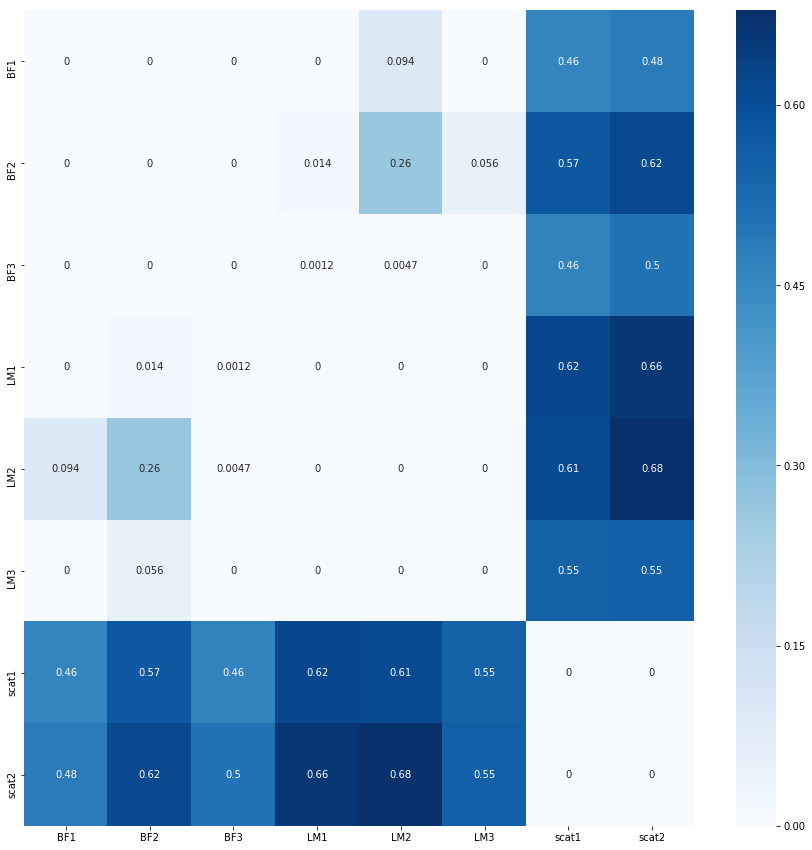

In [29]:
plt.gcf().set_size_inches(15,15)
seaborn.heatmap(rejected_df, annot=True, cmap='Blues')